In [1]:
import tikzplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('default')

In [2]:
model_names = ['normal-24-epochs','adversarial-24-epochs', 'curriculum-adversarial-8-k']

## Analyze success rates per epsilon

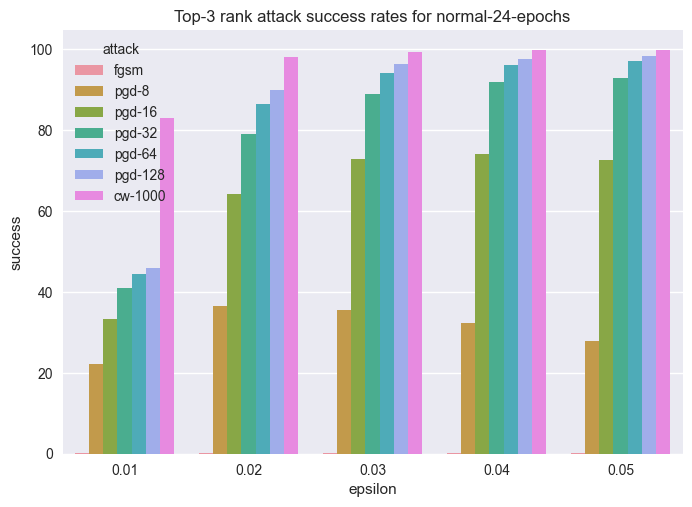

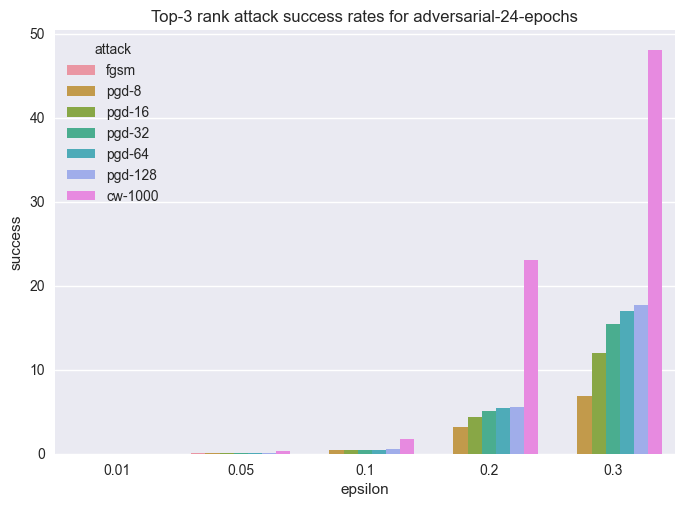

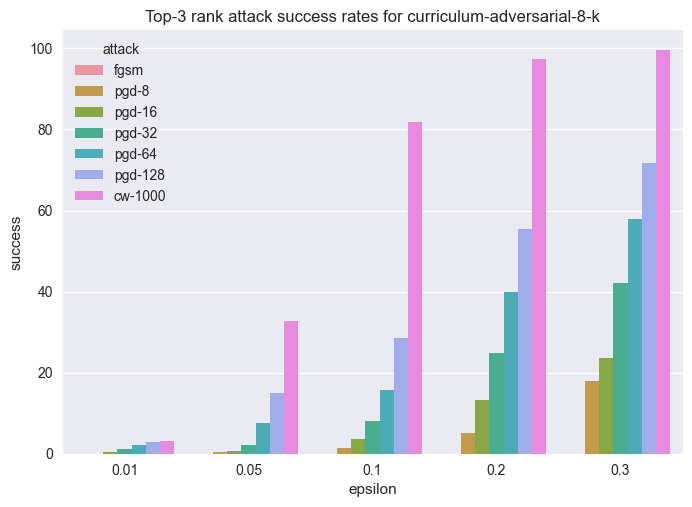

In [3]:
for model_name in model_names:
    if 'adversarial' in model_name:
        epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
    else:
        epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]

    attacks = ['fgsm', 'pgd-8', 'pgd-16', 'pgd-32', 'pgd-64', 'pgd-128', 'cw-1000']

    min_rank = 3

    tuples = []
    for att in attacks:
        for eps in epsilons:
            succeses = pd.read_csv(f'../results/evaluation/{model_name}/test/{eps}/{att}-knn-success.csv')
            succeses = succeses.set_index('rank')
            tuples.append((eps, att, succeses.loc[min_rank].success_rate))

    res = pd.DataFrame(tuples, columns=['epsilon', 'attack', 'success'])

    plt.style.use('seaborn')
    sns.set_palette("husl")
    ax = sns.barplot(data=res, x='epsilon', y='success', hue='attack')
    ax.set_title(f'Top-{min_rank} rank attack success rates for {model_name}')
    tikzplotlib.save(f'../results/figures/success/{model_name}-top-{min_rank}.tex')
    plt.show()

## Analyze cosine distances before and after attack

In [6]:
def quantile_regression_plot(x_col, y_col, data, max_dots=512):
    
    def fit_model(q):
        res = mod.fit(q=q)
        return [q, res.params['Intercept'], res.params[x_col]] + \
                res.conf_int().loc[x_col].tolist()
    
    mod = smf.quantreg(y_col + ' ~ ' + x_col, data)
    quantiles = np.arange(.05, .96, .1)

    models = [fit_model(q) for q in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

    ols = smf.ols(y_col + ' ~ ' + x_col, data).fit()
    print(ols.summary())
    
    ols_ci = ols.conf_int().loc[x_col].tolist()
    ols = dict(a = ols.params['Intercept'],
               b = ols.params[x_col],
               lb = ols_ci[0],
               ub = ols_ci[1])

    
    x = np.arange(data[x_col].min(), data[x_col].max(), data[x_col].max() / 10)
    get_y = lambda a, b: a + b * x

    fig, ax = plt.subplots(figsize=(8, 6))

    for i in range(models.shape[0]):
        y = get_y(models.a[i], models.b[i])
        ax.plot(x, y, linestyle='dotted', color=sns.color_palette('deep')[7])

    y = get_y(ols['a'], ols['b'])

    ax.plot(x, y, color=sns.color_palette()[2])

    samples = data.sample(max_dots)
    plt.plot([0,1], [0,1] , linestyle='dotted', color=sns.color_palette('deep')[2])
    ax.scatter(samples[x_col], samples[y_col], alpha=.25)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    return ax

In [7]:
plt.style.use('seaborn')

attack = 'pgd-32'
epsilon = 0.05

for model_name in model_names:
    ranks = pd.read_csv(f'../results/evaluation/{model_name}/test/{epsilon}/{attack}-knn.csv')
    succeses = pd.read_csv(f'../results/evaluation/{model_name}/test/{epsilon}/{attack}-knn-success.csv')
    ax = quantile_regression_plot('attack_dist', 'adversarial_dist', ranks)
    ax.set_title(f'Quantile regression plot for {model_name} model, attack={attack}, eps={epsilon}')
    tikzplotlib.save(f'../results/figures/scatter/{model_name}-{attack}.tex')
    plt.show()


AttributeError: 'dict' object has no attribute 'summary'

In [25]:
attack = 'cw-1000'
model_name = 'normal-24-epochs'
for rank in [1,3,10,100]:
    print('Top-%d & ' % rank, end='')
    for eps in [0.01,0.02,0.03,0.04,0.05]:
        succeses = pd.read_csv(f'../results/evaluation/{model_name}/test/{eps}/{attack}-knn-success.csv').set_index('rank')
        print('%.2f & ' % succeses.loc[rank].success_rate, end='')
    print()

Top-1 & 74.60 & 94.10 & 96.40 & 97.60 & 97.80 & 
Top-3 & 83.10 & 98.10 & 99.40 & 99.70 & 99.70 & 
Top-10 & 86.60 & 98.40 & 99.50 & 99.90 & 99.90 & 
Top-100 & 91.30 & 99.40 & 99.90 & 100.00 & 100.00 & 
